In [1]:
from keras import layers, models
import tensorflow as tf
# from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError
import os

import shutil
from random import choice

In [2]:
# Đặt đường dẫn thư mục chứa dữ liệu
data_dir = './images'  # Hoặc đặt đường dẫn từ Google Drive

In [3]:

def validate_image(file_path):
    try:
        img = Image.open(file_path)  # Mở thử tệp ảnh
        img.verify()  # Kiểm tra tính hợp lệ của ảnh
        return True
    except (IOError, UnidentifiedImageError):
        return False

# Lọc ra những tệp ảnh hợp lệ trước khi tạo generator
valid_filenames = []
invalid_filenames = [] # Danh sách các file không hợp lệ
for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        if validate_image(file_path):  # Kiểm tra xem ảnh có hợp lệ không
            valid_filenames.append(file_path)
        else:
            invalid_filenames.append(file_path)  # Lưu các ảnh không hợp lệ vào danh sách

# In ra số lượng và danh sách các file không hợp lệ
print(f"Số lượng file ảnh không hợp lệ: {len(invalid_filenames)}")
if invalid_filenames:
    print("Danh sách ảnh không hợp lệ:")
    for invalid_file in invalid_filenames:
        print(invalid_file)

# Sau khi lọc, chỉ còn lại các file hợp lệ
print(f"Số lượng file ảnh hợp lệ: {len(valid_filenames)}")



# Định nghĩa kích thước ảnh và batch size trước khi sử dụng
img_size = (224, 224)
batch_size = 28

# Cân bằng ảnh
def balance_classes(data_dir, target_count):
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            img_files = os.listdir(class_dir)
            current_count = len(img_files)

            if current_count < target_count:
                while len(img_files) < target_count:
                    img_to_copy = choice(img_files)
                    img_path = os.path.join(class_dir, img_to_copy)
                    new_img_path = os.path.join(class_dir, f"copy_{len(img_files)}_{img_to_copy}")
                    shutil.copy(img_path, new_img_path)
                    img_files.append(f"copy_{len(img_files)}_{img_to_copy}")
                print(f"Class {class_name} balanced to {target_count} images.")
            else:
                print(f"Class {class_name} already has enough images.")

balance_classes(data_dir, 1500)


# Tạo ImageDataGenerator từ các tệp đã lọc hợp lệ
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,   # Chuẩn hóa giá trị pixel về khoảng [0, 1]
    rotation_range=20,  # Xoay ngẫu nhiên ảnh trong khoảng 20 độ
    width_shift_range=0.2,  # Dịch chuyển ngang ảnh 20%
    height_shift_range=0.2,  # Dịch chuyển dọc ảnh 20%
    shear_range=0.2,  # Biến đổi hình học
    zoom_range=0.2,   # Zoom ảnh ngẫu nhiên
    horizontal_flip=True,  # Lật ảnh ngẫu nhiên
    validation_split=0.2   # Chia 20% dữ liệu cho tập kiểm tra
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


# Lấy thông tin các nhãn (class)
class_labels = train_generator.class_indices
print("Class labels:", class_labels)

# Xem hình dạng đầu ra của dữ liệu (batch of images, batch of labels)
for images, labels in train_generator:
    print("Batch image shape:", images.shape)
    print("Batch label shape:", labels.shape)
    break


# Tính số bước trên mỗi epoch và mỗi validation
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size


Số lượng file ảnh không hợp lệ: 0
Số lượng file ảnh hợp lệ: 9000
Class duong_xi already has enough images.
Class lan_y already has enough images.
Class luoi_ho already has enough images.
Class nha_dam already has enough images.
Class thuy_tung already has enough images.
Class van_nien_thanh already has enough images.
Found 7200 images belonging to 6 classes.
Found 1800 images belonging to 6 classes.
Class labels: {'duong_xi': 0, 'lan_y': 1, 'luoi_ho': 2, 'nha_dam': 3, 'thuy_tung': 4, 'van_nien_thanh': 5}
Batch image shape: (28, 224, 224, 3)
Batch label shape: (28, 6)


<h3>Mô hình ban đầu</h3>

In [6]:
model = models.Sequential()

# Tầng tích chập đầu tiên
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ hai
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ ba
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng phân loại
model.add(layers.Flatten())  # Làm phẳng dữ liệu từ ma trận 2D thành vector 1D
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(class_labels), activation='softmax'))  # Lớp softmax cho phân loại đa lớp

# Biên dịch mô hình
model.compile(optimizer='adam',
                loss='categorical_crossentropy',  # Sử dụng cho bài toán phân loại đa lớp
                metrics=['accuracy'])

# In cấu trúc mô hình
model.summary()

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,734 (42.61 MB)

 Trainable params: 11,169,734 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=9,  # Số epoch bạn có thể tùy chỉnh
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

Epoch 1/9
257/257 [==============================] - 66s 254ms/step - loss: 1.2937 - accuracy: 0.4919 - val_loss: 0.7918 - val_accuracy: 0.7081
Epoch 2/9
257/257 [==============================] - 67s 259ms/step - loss: 0.6890 - accuracy: 0.7430 - val_loss: 0.5279 - val_accuracy: 0.8131
Epoch 3/9
257/257 [==============================] - 60s 233ms/step - loss: 0.5273 - accuracy: 0.8052 - val_loss: 0.4665 - val_accuracy: 0.8253
Epoch 4/9
257/257 [==============================] - 61s 238ms/step - loss: 0.4481 - accuracy: 0.8366 - val_loss: 0.3379 - val_accuracy: 0.8778
Epoch 5/9
257/257 [==============================] - 59s 228ms/step - loss: 0.3900 - accuracy: 0.8579 - val_loss: 0.3262 - val_accuracy: 0.8895
Epoch 6/9
257/257 [==============================] - 57s 220ms/step - loss: 0.3507 - accuracy: 0.8752 - val_loss: 0.3066 - val_accuracy: 0.8951
Epoch 7/9
257/257 [==============================] - 61s 236ms/step - loss: 0.3244 - accuracy: 0.8864 - val_loss: 0.2838 - val_accuracy:

In [39]:
model.save('plant_recognition_model.h5')

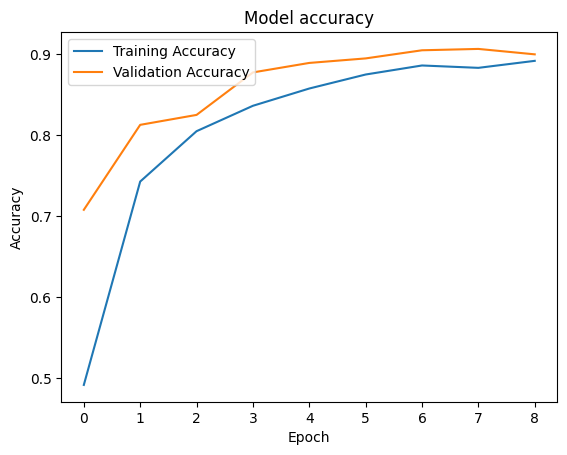

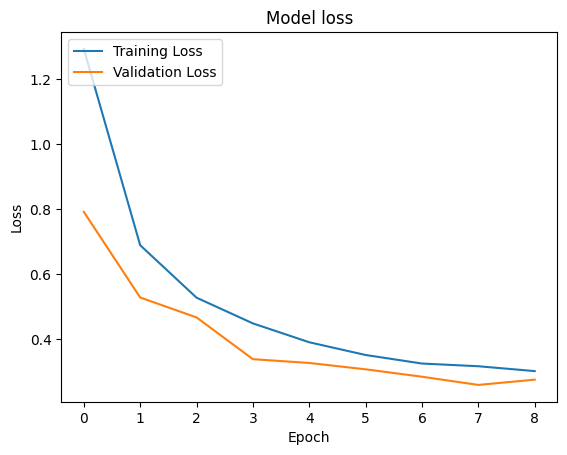

In [40]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot trainingy & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

<h3>Thay đổi kích thước kernel</h3>

In [7]:
model = models.Sequential()

# Tầng tích chập đầu tiên
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ hai
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ ba
model.add(layers.Conv2D(128, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng phân loại
model.add(layers.Flatten())  # Làm phẳng dữ liệu từ ma trận 2D thành vector 1D
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(class_labels), activation='softmax'))  # Lớp softmax cho phân loại đa lớp

# Biên dịch mô hình
model.compile(optimizer='adam',
                loss='categorical_crossentropy',  # Sử dụng cho bài toán phân loại đa lớp
                metrics=['accuracy'])

# In cấu trúc mô hình
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 106, 106, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     9,437,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,696,710 (36.99 MB)

 Trainable params: 9,696,710 (36.99 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=9,  # Số epoch bạn có thể tùy chỉnh
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

Epoch 1/9
257/257 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.6801 - loss: 0.8221 - val_accuracy: 0.7746 - val_loss: 0.5802
Epoch 2/9
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step - accuracy: 0.8214 - loss: 0.6127 - val_accuracy: 0.5000 - val_loss: 0.8043
Epoch 3/9
 15/257 ━━━━━━━━━━━━━━━━━━━━ 3:49 948ms/step - accuracy: 0.7117 - loss: 0.8022

KeyboardInterrupt: 

In [ ]:
model.save('plant_recognition_model-.h5')

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot trainingy & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

<h3>Thêm một tầng tích chập</h3>

In [ ]:
model = models.Sequential()

# Tầng tích chập đầu tiên
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ hai
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ ba
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ tư
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng phân loại
model.add(layers.Flatten())  # Làm phẳng dữ liệu từ ma trận 2D thành vector 1D
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(class_labels), activation='softmax'))  # Lớp softmax cho phân loại đa lớp

# Biên dịch mô hình
model.compile(optimizer='adam',
                loss='categorical_crossentropy',  # Sử dụng cho bài toán phân loại đa lớp
                metrics=['accuracy'])

# In cấu trúc mô hình
model.summary()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=9,  # Số epoch bạn có thể tùy chỉnh
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

In [ ]:
model.save('plant_recognition_model.h5')

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot trainingy & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

<h3>Thay đổi unit trong tâng phân loại</h3>

In [ ]:
#Thay đổi unit trong tầng phân loại
model = models.Sequential()

# Tầng tích chập đầu tiên
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ hai
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ ba
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng phân loại
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))  # Tăng số lượng units lên 256
model.add(layers.Dense(len(class_labels), activation='softmax'))
    
# Biên dịch mô hình
model.compile(optimizer='adam',
                loss='categorical_crossentropy',  # Sử dụng cho bài toán phân loại đa lớp
                metrics=['accuracy'])

# In cấu trúc mô hình
model.summary()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=9,  # Số epoch bạn có thể tùy chỉnh
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

In [ ]:
model.save('plant_recognition_model.h5')

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot trainingy & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [11]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

def test_single_image(img_path, model, class_labels, img_size=(224, 224)):
    """
    Hàm kiểm tra một tấm ảnh với mô hình đã huấn luyện.

    Args:
    - img_path (str): Đường dẫn đến ảnh cần kiểm tra.
    - model (keras.Model): Mô hình đã huấn luyện.
    - class_labels (dict): Từ điển chứa nhãn lớp với các chỉ số.
    - img_size (tuple): Kích thước ảnh đầu vào của mô hình.

    Returns:
    - pred_label (str): Nhãn dự đoán.
    """
    # Tiền xử lý ảnh
    try:
        img = load_img(img_path, target_size=img_size)  # Load ảnh và resize theo kích thước của mô hình
        img_array = img_to_array(img)  # Chuyển đổi ảnh thành array
        img_array = np.expand_dims(img_array, axis=0)  # Thêm chiều cho batch
        img_array /= 255.0  # Chuẩn hóa giá trị pixel

        # Dự đoán
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)  # Lấy lớp có xác suất cao nhất

        # Tra cứu nhãn dự đoán
        pred_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class[0])]

        # In ra kết quả dự đoán
        print(f"Ảnh: {img_path}")
        print(f"Dự đoán: {pred_label}")
        print(f"Xác suất: {np.max(prediction) * 100:.2f}%")
        
        return pred_label
    
    except Exception as e:
        print(f"Đã xảy ra lỗi khi xử lý ảnh: {e}")
        return None

# Ví dụ sử dụng hàm để kiểm tra 1 ảnh mới
img_path = './../test/duong_xi/duong_xi_image_1201.jpg'  # Thay bằng đường dẫn ảnh của bạn
predicted_label = test_single_image(img_path, model, class_labels)





Đã xảy ra lỗi khi xử lý ảnh: [Errno 2] No such file or directory: './../test/duong_xi/duong_xi_image_1201.jpg'


kiểm tra Thu muc

In [22]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

def test_images_in_directory(directory, model, class_labels, img_size=(224, 224)):
    """
    Hàm kiểm tra tất cả các ảnh trong một thư mục với mô hình đã huấn luyện và tính độ chính xác trung bình.

    Args:
    - directory (str): Đường dẫn đến thư mục chứa ảnh cần kiểm tra.
    - model (keras.Model): Mô hình đã huấn luyện.
    - class_labels (dict): Từ điển chứa nhãn lớp với các chỉ số.
    - img_size (tuple): Kích thước ảnh đầu vào của mô hình.

    Returns:
    - float: Độ chính xác trung bình của mô hình trên thư mục ảnh.
    """
    total_images = 0
    correct_predictions = 0
    
    # Duyệt qua các tệp trong thư mục
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        # Kiểm tra xem có phải là tệp ảnh không (có thể thêm kiểm tra định dạng)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            try:
                # Giả định nhãn thực tế là phần đầu tiên của tên tệp (trước dấu '_')
                true_label = filename.split('_')[0]  # Ví dụ: "cat_01.jpg" -> "cat"

                # Tiền xử lý ảnh
                img = load_img(file_path, target_size=img_size)  # Load và resize ảnh
                img_array = img_to_array(img)  # Chuyển đổi ảnh thành array
                img_array = np.expand_dims(img_array, axis=0)  # Thêm chiều cho batch
                img_array /= 255.0  # Chuẩn hóa giá trị pixel

                # Dự đoán
                prediction = model.predict(img_array)
                predicted_class = np.argmax(prediction, axis=1)  # Lấy lớp có xác suất cao nhất
                pred_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class[0])]

                # So sánh nhãn dự đoán với nhãn thực tế
                if pred_label == true_label:
                    correct_predictions += 1
                
                total_images += 1

                # In ra kết quả dự đoán cho từng ảnh
                print(f"Ảnh: {filename}")
                print(f"Dự đoán: {pred_label}")
                print(f"Xác suất: {np.max(prediction) * 100:.2f}%\n")
            
            except Exception as e:
                print(f"Đã xảy ra lỗi khi xử lý ảnh {filename}: {e}")

    # Tính độ chính xác trung bình
    if total_images > 0:
        accuracy = correct_predictions / total_images
        print(f"Độ chính xác trung bình: {accuracy * 100:.2f}% ({correct_predictions}/{total_images})")
        return accuracy
    else:
        print("Không có ảnh hợp lệ trong thư mục.")
        return None

# Ví dụ sử dụng hàm để kiểm tra tất cả ảnh trong thư mục
img_dir = './../test/cay_canh'  # Thay bằng đường dẫn đến thư mục chứa ảnh của bạn
accuracy = test_images_in_directory(img_dir, model, class_labels)


1/1 [==============================] - 0s 25ms/step
Ảnh: hinh_1.jpg
Dự đoán: van_nien_thanh
Xác suất: 99.45%

1/1 [==============================] - 0s 24ms/step
Ảnh: hinh_10.jpg
Dự đoán: luoi_ho
Xác suất: 97.89%

1/1 [==============================] - 0s 21ms/step
Ảnh: hinh_16.jpg
Dự đoán: nha_dam
Xác suất: 99.75%

1/1 [==============================] - 0s 24ms/step
Ảnh: hinh_17.jpg
Dự đoán: nha_dam
Xác suất: 61.84%

1/1 [==============================] - 0s 27ms/step
Ảnh: hinh_18.jpg
Dự đoán: nha_dam
Xác suất: 76.98%

1/1 [==============================] - 0s 23ms/step
Ảnh: hinh_19.jpg
Dự đoán: nha_dam
Xác suất: 99.65%

1/1 [==============================] - 0s 21ms/step
Ảnh: hinh_2.jpg
Dự đoán: van_nien_thanh
Xác suất: 71.92%

1/1 [==============================] - 0s 21ms/step
Ảnh: hinh_20.jpg
Dự đoán: nha_dam
Xác suất: 98.19%

1/1 [==============================] - 0s 25ms/step
Ảnh: hinh_21.jpg
Dự đoán: nha_dam
Xác suất: 74.19%

1/1 [==============================] - 0s 25ms/step
